# Aerospike Connect for Spark - SparkML Tutorial for Python
## Tested with Java 8, Spark 2.4.0, Python 3.7, and Aerospike Spark Connector 2.5

### Setup

Below, a seed address for your Aerospike database cluster is required

Check the given namespace is available, and your feature key is located as per AS_FEATURE_KEY_PATH

Finally, review https://www.aerospike.com/enterprise/download/connectors/ to ensure AEROSPIKE_SPARK_JAR_VERSION is correct

In [1]:
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST ="127.0.0.1"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AS_FEATURE_KEY_PATH = "/etc/aerospike/features.conf"
AEROSPIKE_SPARK_JAR_VERSION="2.5.0"

AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [2]:
# Next we locate the Spark installation - this will be found using the SPARK_HOME environment variable that you will have set 
# if you followed the repository README

import findspark
findspark.init()

In [3]:
# Here we download the Aerospike Spark jar
import urllib
import os

def aerospike_spark_jar_download_url(version=AEROSPIKE_SPARK_JAR_VERSION):
    DOWNLOAD_PREFIX="https://www.aerospike.com/enterprise/download/connectors/aerospike-spark/"
    DOWNLOAD_SUFFIX="/artifact/jar"
    AEROSPIKE_SPARK_JAR_DOWNLOAD_URL = DOWNLOAD_PREFIX+AEROSPIKE_SPARK_JAR_VERSION+DOWNLOAD_SUFFIX
    return AEROSPIKE_SPARK_JAR_DOWNLOAD_URL

def download_aerospike_spark_jar(version=AEROSPIKE_SPARK_JAR_VERSION):
    JAR_NAME="aerospike-spark-assembly-"+AEROSPIKE_SPARK_JAR_VERSION+".jar"
    if(not(os.path.exists(JAR_NAME))) :
        urllib.request.urlretrieve(aerospike_spark_jar_download_url(),JAR_NAME)
    else :
        print(JAR_NAME+" already downloaded")
    return os.path.join(os.getcwd(),JAR_NAME)

AEROSPIKE_JAR_PATH=download_aerospike_spark_jar()
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'

In [4]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType, DoubleType

Get a spark session object and set required Aerospike configuration properties

Set up spark and point aerospike db to AS_HOST

In [16]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)
spark.conf.set("aerospike.namespace",AS_NAMESPACE)
spark.conf.set("aerospike.seedhost",AS_CONNECTION_STRING)
spark.conf.set("aerospike.keyPath",AS_FEATURE_KEY_PATH )

## Create Sample Data and load it into Aerospike

In [17]:
# We create age vs salary data, using three different Gaussian distributions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Create covariance matrix from std devs + correlation
def covariance_matrix(std_dev_1,std_dev_2,correlation):
    return [[std_dev_1 ** 2, correlation * std_dev_1 * std_dev_2], 
           [correlation * std_dev_1 * std_dev_2, std_dev_2 ** 2]]

# Return a bivariate sample given means/std dev/correlation
def age_salary_sample(distribution_params,sample_size):
    mean = [distribution_params["age_mean"], distribution_params["salary_mean"]]
    cov = covariance_matrix(distribution_params["age_std_dev"],distribution_params["salary_std_dev"],
                            distribution_params["age_salary_correlation"])
    return np.random.multivariate_normal(mean, cov, sample_size).T

# Define the characteristics of our age/salary distribution
age_salary_distribution_1 = {"age_mean":25,"salary_mean":50000,
                             "age_std_dev":1,"salary_std_dev":5000,"age_salary_correlation":0.3}

age_salary_distribution_2 = {"age_mean":45,"salary_mean":80000,
                             "age_std_dev":4,"salary_std_dev":10000,"age_salary_correlation":0.7}

age_salary_distribution_3 = {"age_mean":35,"salary_mean":70000,
                             "age_std_dev":2,"salary_std_dev":9000,"age_salary_correlation":0.1}

distribution_data = [age_salary_distribution_1,age_salary_distribution_2,age_salary_distribution_3]

# Sample age/salary data for each distributions
group_1_ages,group_1_salaries = age_salary_sample(age_salary_distribution_1,sample_size=100)
group_2_ages,group_2_salaries = age_salary_sample(age_salary_distribution_2,sample_size=120)
group_3_ages,group_3_salaries = age_salary_sample(age_salary_distribution_3,sample_size=80)

ages=np.concatenate([group_1_ages,group_2_ages,group_3_ages])
salaries=np.concatenate([group_1_salaries,group_2_salaries,group_3_salaries])

print("Data created")

Data created


In [18]:
# Turn the above records into a Data Frame
# First of all, create an array of arrays
inputBuf = []

for  i in range(0, len(ages)) :
     id = i + 1 # Avoid counting from zero
     name = "Individual: {:03d}".format(id)
     # Note we need to make sure values are typed correctly
     # salary will have type numpy.float64 - if it is not cast as below, an error will be thrown
     age = float(ages[i])
     salary = int(salaries[i])
     inputBuf.append((id, name,age,salary))

# Convert to an RDD 
inputRDD = spark.sparkContext.parallelize(inputBuf)
       
# Convert to a data frame using a schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", DoubleType(), True),
    StructField("salary",IntegerType(), True)
])

inputDF=spark.createDataFrame(inputRDD,schema)

#Write the data frame to Aerospike, the id field is used as the primary key
inputDF \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.set", "salary_data")\
.option("aerospike.updateByKey", "id") \
.save()

## Step 1: Load data into a DataFrame using user specified schema 

In [19]:
# If we explicitly set the schema, using the previously created schema object
# we effectively type the rows in the Data Frame

loadedDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.schema(schema) \
.option("aerospike.set", "salary_data").load()

loadedDFWithSchema.show(5)

+---+---------------+------------------+------+
| id|           name|               age|salary|
+---+---------------+------------------+------+
|239|Individual: 239| 34.17676930587447| 74530|
|101|Individual: 101| 42.74153431470734| 66879|
|194|Individual: 194| 47.76512911028296| 95551|
| 31|Individual: 031| 25.01729346533023| 63919|
|139|Individual: 139|48.790294708607526| 85122|
+---+---------------+------------------+------+
only showing top 5 rows



## Step 2: Explore your data

In [20]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

#convert spark df to pandas df
pdf = loadedDFWithSchema.toPandas()

# Describe the data

pdf.describe()

,id,age,salary
count,300.000000,300.000000,300.000000
mean,150.500000,35.559904,66791.943333
std,86.746758,8.912473,14869.353449
min,1.000000,22.618881,38791.000000
25%,75.750000,25.345565,52976.000000
50%,150.500000,35.673442,68783.000000
75%,225.250000,43.727868,78328.000000
max,300.000000,55.063457,98322.000000


22 56


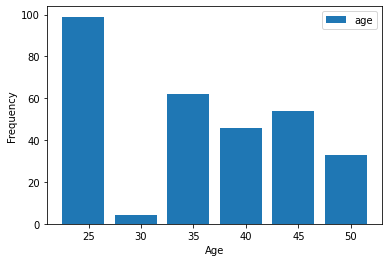

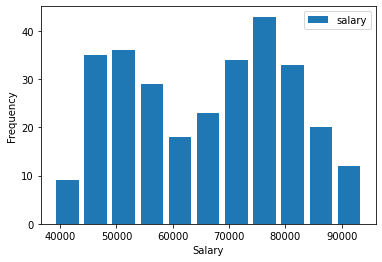

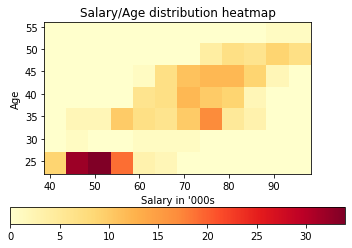

In [21]:
#Histogram - Age
age_min, age_max = int(np.amin(pdf['age'])), math.ceil(np.amax(pdf['age']))
age_bucket_size = 5
print(age_min,age_max)
pdf[['age']].plot(kind='hist',bins=range(age_min,age_max,age_bucket_size),rwidth=0.8)
plt.xlabel('Age',fontsize=10)
plt.legend(loc=None)
plt.show()

#Histogram - Salary
salary_min, salary_max = int(np.amin(pdf['salary'])), math.ceil(np.amax(pdf['salary']))
salary_bucket_size = 5000
pdf[['salary']].plot(kind='hist',bins=range(salary_min,salary_max,salary_bucket_size),rwidth=0.8)
plt.xlabel('Salary',fontsize=10)
plt.legend(loc=None)
plt.show()

# Heatmap
age_bucket_count = math.ceil((age_max - age_min)/age_bucket_size)
salary_bucket_count = math.ceil((salary_max - salary_min)/salary_bucket_size)

x = [[0 for i in range(salary_bucket_count)] for j in range(age_bucket_count)]
for i in range(len(pdf['age'])):
    age_bucket = math.floor((pdf['age'][i] - age_min)/age_bucket_size)
    salary_bucket = math.floor((pdf['salary'][i] - salary_min)/salary_bucket_size)
    x[age_bucket][salary_bucket] += 1

plt.title("Salary/Age distribution heatmap")
plt.xlabel("Salary in '000s")
plt.ylabel("Age")

plt.imshow(x, cmap='YlOrRd', interpolation='nearest',extent=[salary_min/1000,salary_max/1000,age_min,age_max],
           origin="lower")
plt.colorbar(orientation="horizontal")
plt.show()

## Step 3: Create a Segementation model using SparkML

#### A K-Means clustering model is used to create several segments based on age and salary

In [22]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler


#All machine learning algorithms in Spark take as input a Vector type, which must be a set of numerical values.
assembler = VectorAssembler(
    inputCols=["id", "age", "salary"],
    outputCol="features")
data_2 = assembler.transform(loadedDFWithSchema)
data_2.show()

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data_2)

# Make predictions
predictions = model.transform(data_2)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+---+---------------+------------------+------+--------------------+
| id|           name|               age|salary|            features|
+---+---------------+------------------+------+--------------------+
|239|Individual: 239| 34.17676930587447| 74530|[239.0,34.1767693...|
|101|Individual: 101| 42.74153431470734| 66879|[101.0,42.7415343...|
|194|Individual: 194| 47.76512911028296| 95551|[194.0,47.7651291...|
| 31|Individual: 031| 25.01729346533023| 63919|[31.0,25.01729346...|
|139|Individual: 139|48.790294708607526| 85122|[139.0,48.7902947...|
| 14|Individual: 014|23.821849367819627| 50039|[14.0,23.82184936...|
|142|Individual: 142|   41.900346308163| 77074|[142.0,41.9003463...|
|272|Individual: 272| 35.51515262675664| 78120|[272.0,35.5151526...|
| 76|Individual: 076|24.501398941664295| 53245|[76.0,24.50139894...|
|147|Individual: 147| 52.86059009219467| 95568|[147.0,52.8605900...|
| 79|Individual: 079|22.733322137801498| 42284|[79.0,22.73332213...|
| 96|Individual: 096|25.0125422146